# Max Over Time CNN

### Setup

In [1]:
import sys
sys.path.append('..')

import yaml
import torch
import numpy as np
from sklearn.cluster import OPTICS
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import pandas as pd
import plotly.express as px
import nltk
from nltk.corpus import stopwords

from datasets.qa_triplet_dataset import QATripletDataset
from models.max_over_time_cnn import MaxOverTimeCNN

with open('../config/notebook_conf.yml', 'r') as fp:
    config = yaml.load(fp, Loader=yaml.FullLoader)
    
dataset = QATripletDataset(
        config['database_file'], config['database_table'], 
        config['vocab_file'])

dataloader = dataset.build_dataloader(
    batch_size=config['batch_size'], shuffle=True)

encoder = MaxOverTimeCNN(
    len(dataset.get_vocab()), config['wordvec_dim'], config['sentvec_dim'], 
    acceleration=True)

encoder.load_state_dict(torch.load(
    '../artifacts/models/max_over_time_cnn.pt', 
    map_location=torch.device('cpu')))

encoder.eval()

# grab a batch and encode anchor questions to vectors
batch = next(iter(dataloader))
question_str = batch['anc_str']
question_enc = encoder(batch['anc_idxs'])

# detach from pytorch and convert to numpy
question_enc = question_enc.detach().numpy()

[INFO]: using cuda:0 device


### Nearest Neighbor Analysis

In [2]:
# compute nearest neighbors
neigh = NearestNeighbors(n_neighbors=5, metric='cosine')
nbrs = neigh.fit(question_enc)
nn_dist, nn_idx = nbrs.kneighbors(question_enc)

### Print Some Nearest Neighbor Groups

In [3]:
for idx in np.random.choice(len(nn_idx), size=10, replace=False):
    sample = question_str[nn_idx[idx, 0]]
    neighbors = [question_str[i] for i in nn_idx[idx, 1:]]
    
    print(f'Sample:\n\t{sample}')
    print(f'Neighbors:')
    for neighbor in neighbors:
        print(f'\t{neighbor}')
    print('')

Sample:
	mani gram carb one hundr thirti five lb woman per day
Neighbors:
	help peopl diabet
	chang person make order achiev cure diabet type two
	amino acid good diabet
	mean di proverb faith friend medicin life

Sample:
	good idea diabet meal
Neighbors:
	bad diabet eat
	better diabet arrowroot cornflour
	diabet patient eat cashew seed
	chang person make order achiev cure diabet type two

Sample:
	risk factor type two diabet
Neighbors:
	risk develop type ii diabet mellitu
	mani peopl us type diabet
	symptom distinguish type type ii diabet
	import thing know type two diabet

Sample:
	list food high sugar
Neighbors:
	list food high sugar
	consum cinnamon diabet
	ayurveda help someon diabet
	one purchas gourmet chocol suitabl diabet

Sample:
	kind deal exist notebook type comput
Neighbors:
	type food diabet avoid
	type food diabet eat
	type diet person keep angina
	eat best control diabet

Sample:
	place one receiv free diabet suppli
Neighbors:
	anyon assist inform diabet meal plan someo

### Plot Nearest Neighbor Ordered Distances

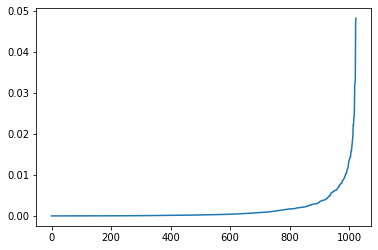

In [4]:
plt.plot(np.sort(nn_dist[:,1], axis=0))

### Cluster Sentence Vectors

In [23]:
from sklearn.cluster import DBSCAN, OPTICS

clustering = DBSCAN(eps=0.009, min_samples=10, n_jobs=-1, metric='cosine')
labels = clustering.fit_predict(question_enc)

# optics = OPTICS(min_samples=10, metric='cosine')
# optics.fit(question_enc)
# labels = optics.labels_

num_clusters = len(np.unique(labels))
perc_labeled = 100 * (len(labels[labels != -1]) / len(labels))
print(f'[Num. Clusters]: {num_clusters}, [Perc. Non-Outliers]: {perc_labeled:.1f}')

[Num. Clusters]: 4, [Perc. Non-Outliers]: 83.7


### Project Sentence Vectors

In [24]:
tsne = TSNE(n_components=3, metric='cosine')
question_proj = tsne.fit_transform(question_enc)

df = pd.DataFrame({
    'sentence': question_str,
    'vector': [x for x in question_enc],
    'label': labels,
    'pc_1': question_proj[:, 0],
    'pc_2': question_proj[:, 1],
    'pc_3': question_proj[:, 2],
})

fig = px.scatter_3d(
    df, x='pc_1', y='pc_2', z='pc_3', color='pc_3', 
    hover_data=['sentence'])
fig.update_traces(marker_size=5)
fig.update_layout(
    title='Projected Question Vector Manifold',
    legend={'title': 'Cluster Summaries', 'itemclick': 'toggleothers'},
    height=500,
)
fig.show()

### Cluster Summaries

In [25]:
# get list standard stop words and add some custom ones to this list
stop_words = stopwords.words('english')
extras = ['diabetes', '?', '.', '!', '<unk>']
stop_words += extras

# initialize word stemmer
stemmer = nltk.stem.PorterStemmer()

# stem stop words
stop_words = [stemmer.stem(word) for word in stop_words]

# add a summary column
df['summary'] = None

# add column for average cluster vector
df['avg_vector'] = None

# infer cluster topics
for label in sorted(df['label'].unique()):
    # get all samples with this label
    samples = df[df['label'] == label]['sentence']
    
    # get all vectors with this label
    vectors = np.stack(df[df['label'] == label]['vector'].to_numpy())
    
    # compute average vec for this cluster label
    avg_vector = np.mean(vectors, axis=0)
    
    # add average vector to dataframe
    df.loc[df['label'] == label, 'avg_vector'] = df.loc[df['label'] == label, 'avg_vector'].map(
        lambda x: avg_vector)
    
    # convert samples to a list
    samples = samples.tolist()
    
    # tokenize samples by whitespace
    tokens = [[word for word in sentence.split(' ')] for sentence in samples]
    
    # flatten samples list
    tokens = [inner for outer in tokens for inner in outer]
    
    # stem tokens
    tokens = [stemmer.stem(token) for token in tokens]
    
    # filter stopwords
    tokens = [token for token in tokens if not token in stop_words]
    
    # get token frequencies
    fdist = nltk.FreqDist(tokens)
    
    # get summary string from 5 most frequent tokens
    summary = ' '.join([token for token, _ in fdist.most_common(5)])
    
    # add summary string to dataframe
    df.loc[df['label'] == label, 'summary'] = summary
    
    
print('Coarse Cluster Summaries:\n')
for i, summary in enumerate(df['summary'].unique()):
    print(f'{i+1}. {summary}')

Coarse Cluster Summaries:

1. blood sugar insulin level gluco
2. sugar blood type insulin eat
3. diet eat food sugar good
4. type cau two one symptom


In [26]:
fig = px.scatter_3d(
    df, x='pc_1', y='pc_2', z='pc_3', color='summary', 
    hover_data=['summary', 'sentence'])
fig.update_traces(marker_size=5)
fig.update_layout(
    title='Projected Question Vector Manifold',
    legend={'title': 'Cluster Summaries', 'itemclick': 'toggleothers'},
    height=500,
)
fig.show()